Analysis of columns against the targeted column 'Is Fraud?'

Covered: Time of day, weekend, debt ratio, age, online, international, dark web, debt, yearly income, state
<br>Should be covered: day of week, distance, FICO, amount

In [1]:
#Libraries/Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Initial read

In [2]:
df = pd.read_csv("data/tab_set.csv")
df.head()

,Unnamed: 0,Amount,Use Chip,Merchant State,Errors?,Is Fraud?,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,...,Card on Dark Web,International,Online,Age_at_transaction,income_to_debt,day_of_week,is_weekend,timestamp,time_of_day,distances
0,0,134.09,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,...,0,0,0,36,0.467789,6,1,1.030861e+09,Morning,0.000000
1,1,38.48,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,...,0,0,0,36,0.467789,6,1,1.030863e+09,Morning,33.540588
2,2,120.34,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,...,0,0,0,36,0.467789,0,0,1.030948e+09,Morning,33.540588
3,3,128.95,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,...,0,0,0,36,0.467789,0,0,1.030989e+09,Afternoon,33.540588
4,4,104.71,Swipe Transaction,CA,No Error,0,29278,59696,127613,787,...,0,0,0,36,0.467789,1,0,1.031034e+09,Morning,0.000000


In [3]:
df['Errors?'].value_counts()

Errors?
No Error                                           5522961
Insufficient Balance                                 56205
Bad PIN                                              13635
Technical Glitch                                     11354
Bad Card Number                                       3485
Bad Expiration                                        2994
Bad CVV                                               2875
Bad Zipcode                                            398
Insufficient Balance,Technical Glitch                  124
Bad PIN,Insufficient Balance                           112
Bad PIN,Technical Glitch                                37
Bad CVV,Insufficient Balance                            24
Bad Card Number,Insufficient Balance                    24
Bad Expiration,Insufficient Balance                     19
Bad Card Number,Bad CVV                                 17
Bad Card Number,Bad Expiration                          14
Bad Expiration,Bad CVV                          

## Financial section (income/debt)
Debt ratio to fraud (table): 
Expected trend- as ratio increases, fraud % increases

In [4]:
ratio_df = df
bins = [i / 10 for i in range(0, 11)] + [float('inf')]
labels = [f'{i/10:.1f}-{(i+1)/10:.1f}' for i in range(0, 10)] + ['>1.0']

# Bin the 'income_to_debt' column
ratio_df['Income to Debt Bin'] = pd.cut(ratio_df['income_to_debt'], bins=bins, labels=labels, right=False)

# Group by Income to Debt Bin and Is Fraud, then count occurrences
income_debt_fraud_counts = ratio_df.groupby(['Income to Debt Bin', 'Is Fraud?']).size().reset_index(name='Count')

# Pivot the data to create a table format
pivot_df = income_debt_fraud_counts.pivot(index='Income to Debt Bin', columns='Is Fraud?', values='Count').fillna(0).reset_index()

# Rename the columns for better readability
pivot_df.columns = ['Income to Debt Bin', 'No Fraud (0)', 'Fraud (1)']

# Calculate the total transactions per income to debt bin
pivot_df['Total Transactions'] = pivot_df['No Fraud (0)'] + pivot_df['Fraud (1)']

# Calculate the percentage of fraudulent transactions
pivot_df['Percent Fraud'] = (pivot_df['Fraud (1)'] / pivot_df['Total Transactions']) * 100

# Print the resulting table
print(pivot_df)

   Income to Debt Bin  No Fraud (0)  Fraud (1)  Total Transactions  \
0             0.0-0.1             0          0                   0   
1             0.1-0.2             0          0                   0   
2             0.2-0.3         28595         24               28619   
3             0.3-0.4        421174        559              421733   
4             0.4-0.5        641871        736              642607   
5             0.5-0.6        873871        947              874818   
6             0.6-0.7        357821        433              358254   
7             0.7-0.8        601424        588              602012   
8             0.8-0.9        271122        295              271417   
9             0.9-1.0        161287        170              161457   
10               >1.0       2250553       2840             2253393   

    Percent Fraud  
0             NaN  
1             NaN  
2        0.083860  
3        0.132548  
4        0.114533  
5        0.108251  
6        0.120864  

Debt amount (binned) against fraud (table)
Expected trend: As income increases, % fraud decreases

In [5]:
debt_df = df
# Define the bins and labels
bins = [0, 15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000, float('inf')]
labels = [
    '0-15000', '15001-30000', '30001-45000', '45001-60000', '60001-75000',
    '75001-90000', '90001-105000', '105001-120000', '120001-135000', '135001-150000', '>150000'
]

# Bin the 'Yearly Income - Person' column
debt_df['Debt Bin'] = pd.cut(debt_df['Total Debt'], bins=bins, labels=labels, right=False)

# Group by Income Bin and Is Fraud, then count occurrences
income_fraud_counts = debt_df.groupby(['Debt Bin', 'Is Fraud?']).size().reset_index(name='Count')

# Pivot the data to create a table format
pivot_df = income_fraud_counts.pivot(index='Debt Bin', columns='Is Fraud?', values='Count').fillna(0).reset_index()

# Rename the columns for better readability
pivot_df.columns = ['Debt', 'No Fraud (0)', 'Fraud (1)']

# Calculate the total transactions per income bin
pivot_df['Total Transactions'] = pivot_df['No Fraud (0)'] + pivot_df['Fraud (1)']

# Calculate the percentage of fraudulent transactions
pivot_df['Percent Fraud'] = (pivot_df['Fraud (1)'] / pivot_df['Total Transactions']) * 100

# Print the resulting table
print(pivot_df)

             Debt  No Fraud (0)  Fraud (1)  Total Transactions  Percent Fraud
0         0-15000       1284408       1636             1286044       0.127212
1     15001-30000        630846        871              631717       0.137878
2     30001-45000        665079        683              665762       0.102589
3     45001-60000        594357        518              594875       0.087077
4     60001-75000        658303        814              659117       0.123499
5     75001-90000        394125        621              394746       0.157316
6    90001-105000        249991        290              250281       0.115870
7   105001-120000        416583        464              417047       0.111258
8   120001-135000        218181        174              218355       0.079687
9   135001-150000        120299        121              120420       0.100482
10        >150000        375546        400              375946       0.106398


Yearly income (binned) against fraud (table)
Expected trend: As income increases, % fraud decreases

In [6]:
income_df = df
# Define the bins and labels
bins = [0, 15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000, float('inf')]
labels = [
    '0-15000', '15001-30000', '30001-45000', '45001-60000', '60001-75000',
    '75001-90000', '90001-105000', '105001-120000', '120001-135000', '135001-150000', '>150000'
]

# Bin the 'Yearly Income - Person' column
income_df['Income Bin'] = pd.cut(income_df['Yearly Income - Person'], bins=bins, labels=labels, right=False)

# Group by Income Bin and Is Fraud, then count occurrences
income_fraud_counts = income_df.groupby(['Income Bin', 'Is Fraud?']).size().reset_index(name='Count')

# Pivot the data to create a table format
pivot_df = income_fraud_counts.pivot(index='Income Bin', columns='Is Fraud?', values='Count').fillna(0).reset_index()

# Rename the columns for better readability
pivot_df.columns = ['Income Bin', 'No Fraud (0)', 'Fraud (1)']

# Calculate the total transactions per income bin
pivot_df['Total Transactions'] = pivot_df['No Fraud (0)'] + pivot_df['Fraud (1)']

# Calculate the percentage of fraudulent transactions
pivot_df['Percent Fraud'] = (pivot_df['Fraud (1)'] / pivot_df['Total Transactions']) * 100

# Print the resulting table
print(pivot_df)


       Income Bin  No Fraud (0)  Fraud (1)  Total Transactions  Percent Fraud
0         0-15000         86904        141               87045       0.161985
1     15001-30000        753214        899              754113       0.119213
2     30001-45000       2347287       2922             2350209       0.124329
3     45001-60000       1310321       1631             1311952       0.124319
4     60001-75000        538260        450              538710       0.083533
5     75001-90000        285641        326              285967       0.113999
6    90001-105000        113966         69              114035       0.060508
7   105001-120000         92551         72               92623       0.077734
8   120001-135000             0          0                   0            NaN
9   135001-150000             0          0                   0            NaN
10        >150000         79574         82               79656       0.102943


-----------------------------------------------------
Age against fraud (line graphs and table)

In [7]:
# Group by Time of Day and Is Fraud, then count occurrences
time_fraud_counts = df.groupby(['time_of_day', 'Is Fraud?']).size().reset_index(name='Count')

# Pivot the data to create a table format
pivot_df = time_fraud_counts.pivot(index='time_of_day', columns='Is Fraud?', values='Count').fillna(0).reset_index()

# Rename the columns for better readability
pivot_df.columns = ['Time of Day', 'No Fraud (0)', 'Fraud (1)']

# Calculate the total transactions per time of day
pivot_df['Total Transactions'] = pivot_df['No Fraud (0)'] + pivot_df['Fraud (1)']

# Calculate the percentage of fraudulent transactions
pivot_df['Percent Fraud'] = (pivot_df['Fraud (1)'] / pivot_df['Total Transactions']) * 100

# Print the resulting table
print(pivot_df)

  Time of Day  No Fraud (0)  Fraud (1)  Total Transactions  Percent Fraud
0   Afternoon       2043880       2985             2046865       0.145833
1     Evening        769017        465              769482       0.060430
2     Morning       2281923       2749             2284672       0.120324
3       Night        512898        393              513291       0.076565


In [8]:
pd.set_option('display.max_columns', None)
# Group by Merchant State and Is Fraud, then count occurrences
time_fraud_counts = df.groupby(['Merchant State', 'Is Fraud?']).size().reset_index(name='Count')

# Pivot the data to create a table format
pivot_df = time_fraud_counts.pivot(index='Merchant State', columns='Is Fraud?', values='Count').fillna(0).reset_index()

# Rename the columns for better readability
pivot_df.columns = ['Merchant State', 'No Fraud (0)', 'Fraud (1)']

# Calculate the total transactions per Merchant State
pivot_df['Total Transactions'] = pivot_df['No Fraud (0)'] + pivot_df['Fraud (1)']

# Calculate the percentage of fraudulent transactions
pivot_df['Percent Fraud'] = (pivot_df['Fraud (1)'] / pivot_df['Total Transactions']) * 100

# Sort by Percent Fraud in descending order
pivot_df = pivot_df.sort_values(by='Percent Fraud', ascending=False)

# Print the resulting DataFrame
print(pivot_df)

    Merchant State  No Fraud (0)  Fraud (1)  Total Transactions  Percent Fraud
41            Fiji           0.0        7.0                 7.0     100.000000
5          Algeria           0.0      185.0               185.0     100.000000
149         Tuvalu           0.0       15.0                15.0     100.000000
107        Nigeria           9.0       42.0                51.0      82.352941
51           Haiti          33.0       88.0               121.0      72.727273
..             ...           ...        ...                 ...            ...
52        Honduras           2.0        0.0                 2.0       0.000000
49       Guatemala          20.0        0.0                20.0       0.000000
48          Greece         236.0        0.0               236.0       0.000000
47           Ghana           5.0        0.0                 5.0       0.000000
165       Zimbabwe          15.0        0.0                15.0       0.000000

[166 rows x 5 columns]


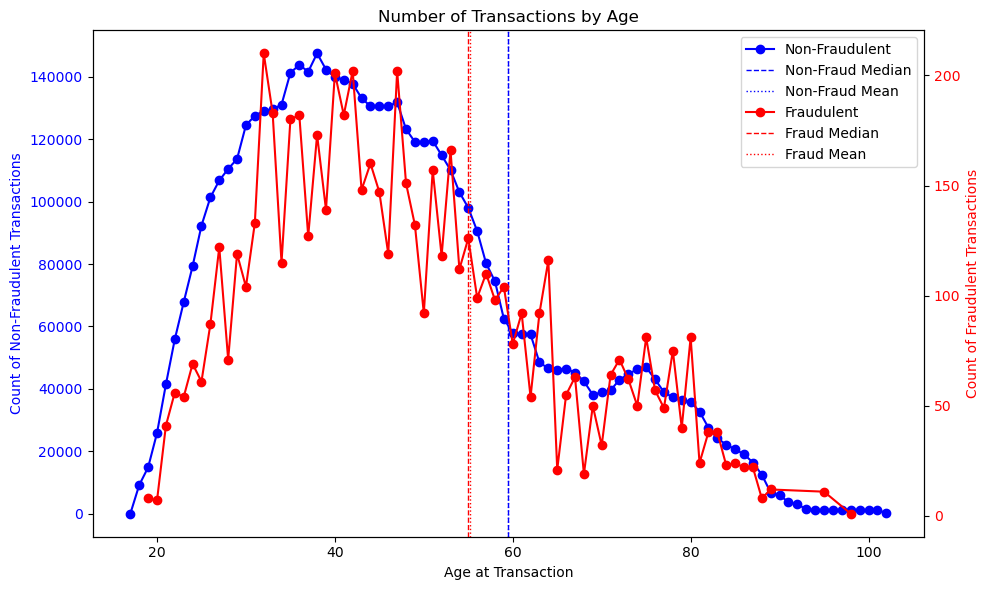

In [19]:
# Group by Age and Is Fraud, then count occurrences
age_fraud_counts = df.groupby(['Age_at_transaction', 'Is Fraud?']).size().reset_index(name='Count')

# Separate data for 'Is Fraud' = 0 and 'Is Fraud?' = 1
fraud_0 = age_fraud_counts[age_fraud_counts['Is Fraud?'] == 0]
fraud_1 = age_fraud_counts[age_fraud_counts['Is Fraud?'] == 1]

# Calculate medians and means
median_fraud_0 = fraud_0['Age_at_transaction'].median()
mean_fraud_0 = fraud_0['Age_at_transaction'].mean()

median_fraud_1 = fraud_1['Age_at_transaction'].median()
mean_fraud_1 = fraud_1['Age_at_transaction'].mean()

# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for 'Is Fraud' = 0 on the primary y-axis
ax1.plot(fraud_0['Age_at_transaction'], fraud_0['Count'], marker='o', linestyle='-', color='blue', label='Non-Fraudulent')
ax1.set_xlabel('Age at Transaction')
ax1.set_ylabel('Count of Non-Fraudulent Transactions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add mean and median lines for non-fraudulent transactions
ax1.axvline(x=median_fraud_0, color='blue', linestyle='--', linewidth=1, label='Non-Fraud Median')
ax1.axvline(x=mean_fraud_0, color='blue', linestyle=':', linewidth=1, label='Non-Fraud Mean')

# Create a secondary y-axis for 'Is Fraud' = 1
ax2 = ax1.twinx()
ax2.plot(fraud_1['Age_at_transaction'], fraud_1['Count'], marker='o', linestyle='-', color='red', label='Fraudulent')
ax2.set_ylabel('Count of Fraudulent Transactions', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add mean and median lines for fraudulent transactions
ax2.axvline(x=median_fraud_1, color='red', linestyle='--', linewidth=1, label='Fraud Median')
ax2.axvline(x=mean_fraud_1, color='red', linestyle=':', linewidth=1, label='Fraud Mean')

# Add a title
plt.title('Number of Transactions by Age')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Adjust layout to make room for both y-labels
fig.tight_layout()

# Show the plot
plt.show()

Time of day

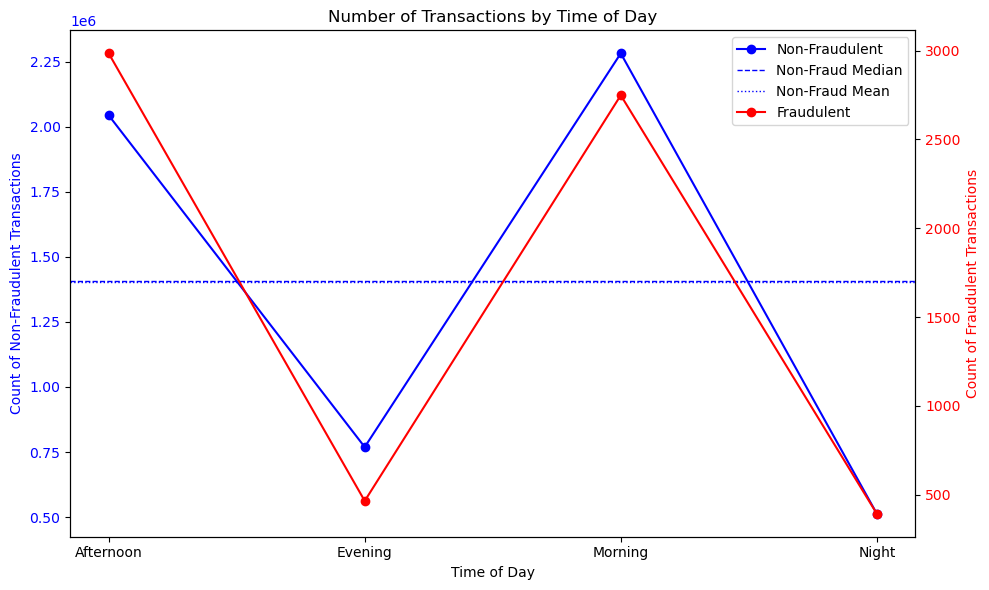

In [22]:
# Group by time_of_day and Is Fraud, then count occurrences
time_fraud_counts = df.groupby(['time_of_day', 'Is Fraud?']).size().reset_index(name='Count')

# Separate data for 'Is Fraud' = 0 and 'Is Fraud?' = 1
fraud_0 = time_fraud_counts[time_fraud_counts['Is Fraud?'] == 0]
fraud_1 = time_fraud_counts[time_fraud_counts['Is Fraud?'] == 1]

# Calculate medians and means
median_fraud_0 = fraud_0['Count'].median()
mean_fraud_0 = fraud_0['Count'].mean()

median_fraud_1 = fraud_1['Count'].median()
mean_fraud_1 = fraud_1['Count'].mean()

# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for 'Is Fraud' = 0 on the primary y-axis
ax1.plot(fraud_0['time_of_day'], fraud_0['Count'], marker='o', linestyle='-', color='blue', label='Non-Fraudulent')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Count of Non-Fraudulent Transactions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add mean and median lines for non-fraudulent transactions
ax1.axhline(y=median_fraud_0, color='blue', linestyle='--', linewidth=1, label='Non-Fraud Median')
ax1.axhline(y=mean_fraud_0, color='blue', linestyle=':', linewidth=1, label='Non-Fraud Mean')

# Create a secondary y-axis for 'Is Fraud' = 1
ax2 = ax1.twinx()
ax2.plot(fraud_1['time_of_day'], fraud_1['Count'], marker='o', linestyle='-', color='red', label='Fraudulent')
ax2.set_ylabel('Count of Fraudulent Transactions', color='red')
ax2.tick_params(axis='y', labelcolor='red')



# Add a title
plt.title('Number of Transactions by Time of Day')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Adjust layout to make room for both y-labels
fig.tight_layout()

# Show the plot
plt.show()

## Binary columns against fraud (heat maps)
On the dark web(no data/irrelevant)

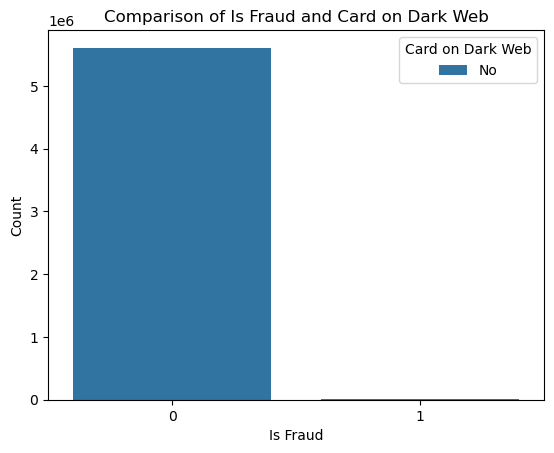

In [11]:
sns.countplot(data=df, x='Is Fraud?', hue='Card on Dark Web')
plt.title('Comparison of Is Fraud and Card on Dark Web')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.legend(title='Card on Dark Web', labels=['No', 'Yes'])
plt.show()

Fraud for international transactions

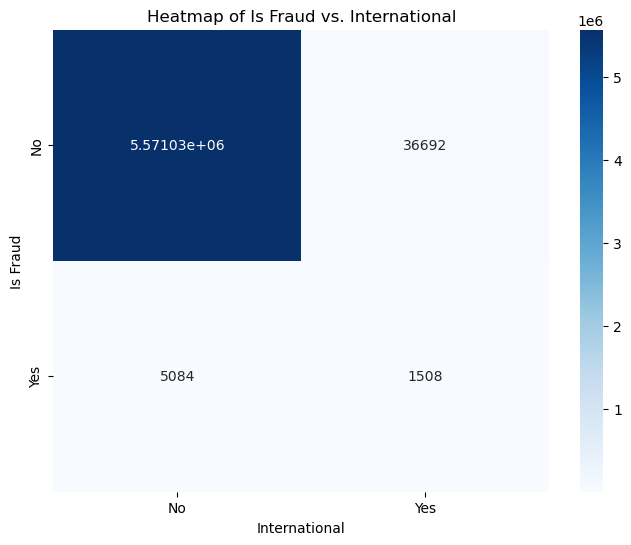

In [12]:
# Count occurrences of each combination of 'Is Fraud' and 'Card on Dark Web'
count_df = df.groupby(['Is Fraud?', 'International']).size().reset_index(name='Count')

# Pivot the data for the heatmap
pivot_df = count_df.pivot(index='Is Fraud?', columns='International', values='Count').fillna(0)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Heatmap of Is Fraud vs. International')
plt.xlabel('International')
plt.ylabel('Is Fraud')
plt.show()

In [13]:
int_fraud_per = 1508 / (36692 + 1508) * 100
no_int_fraud_per = 5084 / (5571030 + 5084) * 100
is_fraud = 1508 / (5084 + 1508) * 100

print(f"Percent of fraud in international transactions = {int_fraud_per}")
print(f"Percent of fraud in non-international transactions = {no_int_fraud_per}")
print(f"Percent of fraud seen in international transactions compared to non-international transactions = {is_fraud}")

Percent of fraud in international transactions = 3.947643979057592
Percent of fraud in non-international transactions = 0.09117460654498813
Percent of fraud seen in international transactions compared to non-international transactions = 22.87621359223301


Fraud for online transactions

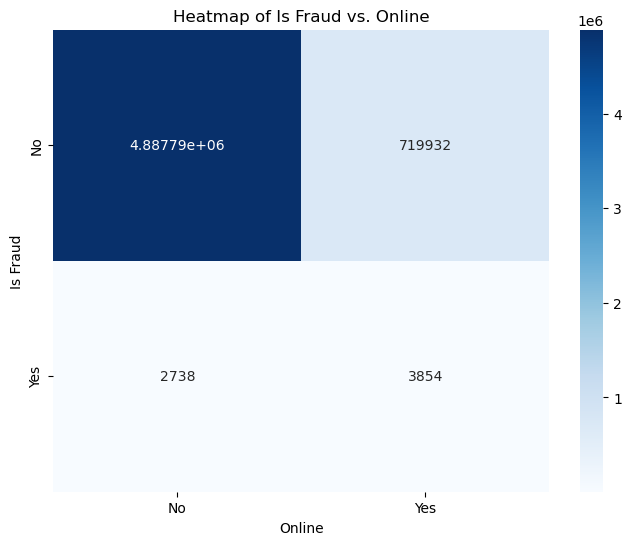

In [14]:
# Count occurrences of each combination of 'Is Fraud' and 'Card on Dark Web'
count_df = df.groupby(['Is Fraud?', 'Online']).size().reset_index(name='Count')

# Pivot the data for the heatmap
pivot_df = count_df.pivot(index='Is Fraud?', columns='Online', values='Count').fillna(0)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Heatmap of Is Fraud vs. Online')
plt.xlabel('Online')
plt.ylabel('Is Fraud')
plt.show()

In [15]:
online_fraud_per = 3854 / (719932 + 3854) * 100
offline_fraud_per = 2738 / (4887790 + 2738) * 100
online_all_fraud = 3854 / (3854 + 2738) * 100
perc_online_transactions = 719932 / (719932 + 4887790) * 100

print(f"Percent of fraud in online transactions = {online_fraud_per}")
print(f"Percent of fraud in offline transactions = {offline_fraud_per}")
print(f"Percent of fraud seen in online transactions compared to offline transactions = {online_all_fraud}")
print(f"Percent of transactions that are online = {perc_online_transactions}")


Percent of fraud in online transactions = 0.5324778318453244
Percent of fraud in offline transactions = 0.055985774951089126
Percent of fraud seen in online transactions compared to offline transactions = 58.46480582524271
Percent of transactions that are online = 12.838225575376242


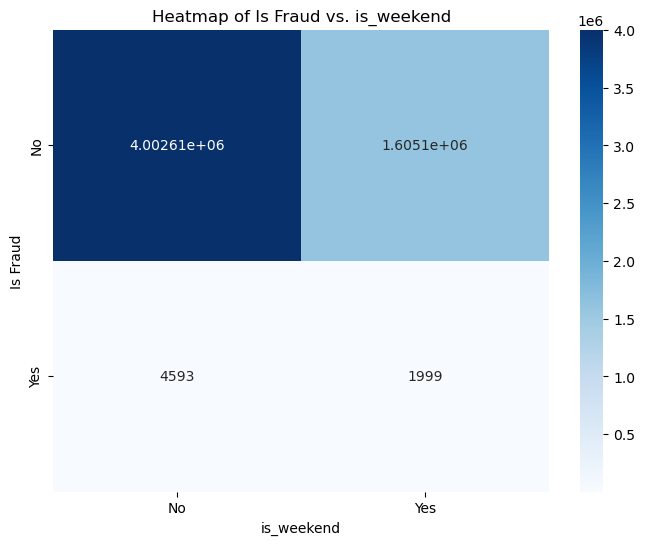

In [16]:
# Count occurrences of each combination of 'Is Fraud' and 'Card on Dark Web'
count_df = df.groupby(['Is Fraud?', 'is_weekend']).size().reset_index(name='Count')

# Pivot the data for the heatmap
pivot_df = count_df.pivot(index='Is Fraud?', columns='is_weekend', values='Count').fillna(0)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Heatmap of Is Fraud vs. is_weekend')
plt.xlabel('is_weekend')
plt.ylabel('Is Fraud')
plt.show()